In [1]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend
from keras import losses
from keras.constraints import nonneg
from keras.initializers import Constant
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from scipy.io import savemat, loadmat

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def load_images_from_folder(folder):
    images = np.zeros([1,256,256,1])
    images_noise_CW = np.zeros([1,256,256,1])
    images_noise_pulse = np.zeros([1,256,256,1])
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        E_img = np.mean(img)
        E_noise_CW =  E_img / 22
        E_noise_pulse = 2 * E_noise_CW
        img_noise_CW = img + np.random.poisson(E_noise_CW,(256,256))
        img_noise_pulse = img + np.random.poisson(E_noise_pulse,(256,256))
        #image = plt.imshow(img)
        #plt.show()
        if img is not None:
            img = np.expand_dims(np.expand_dims(img, axis = 2), axis = 0)
            images = np.append(images, img, axis=0)
            img_noise_CW = np.expand_dims(np.expand_dims(img_noise_CW, axis = 2), axis = 0)
            images_noise_CW = np.append(images_noise_CW, img_noise_CW, axis=0)
            img_noise_pulse = np.expand_dims(np.expand_dims(img_noise_pulse, axis = 2), axis = 0)
            images_noise_pulse = np.append(images_noise_pulse, img_noise_pulse, axis=0)

    images = images[1:,:,:,:]
    images_noise_CW = images_noise_CW[1:,:,:,:]
    images_noise_pulse = images_noise_pulse[1:,:,:,:]
    return images, images_noise_CW, images_noise_pulse
def load_train():
    images, images_noise_CW, images_noise_pulse = load_images_from_folder('data_train1')
    return images, images_noise_CW, images_noise_pulse

def load_test():
    images, images_noise_CW, images_noise_pulse = load_images_from_folder('data_test')
    return images, images_noise_CW, images_noise_pulse


In [2]:
class GDCI_4():
    # first 4 are for alpha, next 4 for beta
    def __init__(self):
        # Input shape
        self.channels = 1
        self.lr_height = 256                 # Low resolution height
        self.lr_width = 256                  # Low resolution width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = self.lr_height   # High resolution height
        self.hr_width = self.lr_width     # High resolution width
        self.hr_shape = (self.lr_height, self.lr_width, self.channels)
        self.lambda_step = 0.01
        self.soft_thr = 0.01
        
        opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
        # Build the generator
        self.generator = self.build_generator()
        def regularized_loss(y_true, y_pred):
            return backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))) + 0.01*backend.mean(backend.square(y_pred[:,:,:,1]))
        def rmse(y_true, y_pred):
            return backend.sqrt(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))))
        self.generator.compile(loss=regularized_loss, optimizer=opt, metrics=rmse)

    def build_generator(self):    
        # Low resolution image input
        inputs = Input(shape=self.lr_shape)
        subsampling_rate = 4
        conv2d = Conv2D(1, subsampling_rate, strides=(subsampling_rate, subsampling_rate), activation = None, padding = 'same', data_format='channels_last', kernel_initializer = Constant(value = 1/subsampling_rate/subsampling_rate), kernel_constraint=nonneg())
        measurement = conv2d(inputs)
        measurement = GaussianNoise(0.4251/11)(measurement)
        print('**********measurement',measurement)

        r1 = conv2d(inputs)
        temp = 0.01
        R1 = subtract([measurement, Lambda(lambda x: temp*x)(subtract([r1,measurement]))])
        conv1_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R1)
        f11 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv1_2 = f11(conv1_1)
        print(conv1_2)
        conv1_symm = f11(conv1_1)
        print(conv1_symm)
        f12 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv1_3 = f12(conv1_2)
        conv1_symm = f12(conv1_symm)
        temp = self.soft_thr
        conv1_4 = multiply([Lambda(lambda x: backend.sign(x))(conv1_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv1_3)))])
        f13 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv1_5 = f13(conv1_4)
        conv1_symm = f13(conv1_symm)
        f14 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv1_6 = f14(conv1_5)       
        conv1_symm = f14(conv1_symm)       
        conv1_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv1_6)                
        conv1_7 = add([conv1_7, R1])
        conv1_8 = subtract([conv1_symm, conv1_1])
        
        temp = 0.01
        R2 = subtract([conv1_7, Lambda(lambda x: temp*x)(subtract([conv1_7,measurement]))])
        conv2_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R2)
        f21 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv2_2 = f21(conv2_1)
        conv2_symm = f21(conv2_1)
        f22 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv2_3 = f22(conv2_2)
        conv2_symm = f22(conv2_symm)
        temp = self.soft_thr
        conv2_4 = multiply([Lambda(lambda x: backend.sign(x))(conv2_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv2_3)))])
        f23 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv2_5 = f23(conv2_4)
        conv2_symm = f23(conv2_symm)
        f24 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv2_6 = f24(conv2_5)       
        conv2_symm = f24(conv2_symm)       
        conv2_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv2_6)                
        conv2_7 = add([conv2_7, R2])
        conv2_8 = subtract([conv2_symm, conv2_1])
        
        temp = 0.01
        R3 = subtract([conv2_7, Lambda(lambda x: temp*x)(subtract([conv2_7,measurement]))])
        conv3_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R3)
        f31 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv3_2 = f31(conv3_1)
        conv3_symm = f31(conv3_1)
        f32 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv3_3 = f32(conv3_2)
        conv3_symm = f32(conv3_symm)
        temp = self.soft_thr
        conv3_4 = multiply([Lambda(lambda x: backend.sign(x))(conv3_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv3_3)))])
        f33 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv3_5 = f33(conv3_4)
        conv3_symm = f33(conv3_symm)
        f34 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv3_6 = f34(conv3_5)       
        conv3_symm = f34(conv3_symm)       
        conv3_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv3_6)                
        conv3_7 = add([conv3_7, R3])
        conv3_8 = subtract([conv3_symm, conv3_1])
        
        temp = 0.01
        R4 = subtract([conv3_7,Lambda(lambda x: temp*x)(subtract([conv3_7,measurement]))])
        conv4_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R4)
        f41 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv4_2 = f41(conv4_1)
        conv4_symm = f41(conv4_1)
        f42 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv4_3 = f42(conv4_2)
        conv4_symm = f42(conv4_symm)
        temp = self.soft_thr
        conv4_4 = multiply([Lambda(lambda x: backend.sign(x))(conv4_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv4_3)))])
        f43 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv4_5 = f43(conv4_4)
        conv4_symm = f43(conv4_symm)
        f44 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv4_6 = f44(conv4_5)       
        conv4_symm = f44(conv4_symm)       
        conv4_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv4_6)                
        conv4_7 = add([conv4_7, R4])
        conv4_8 = subtract([conv4_symm, conv4_1])        


        output1 = Concatenate(axis = 3)([conv1_4, conv1_7])
        print(output1)
        GLB1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(output1)
        GLB1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB1)

        GLB2 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv2_4, conv2_7, GLB1]))
        GLB2 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB2)


        GLB3 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv3_4, conv3_7, GLB2]))
        GLB3 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB3)


        GLB4 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv4_4, conv4_7, GLB3]))
        GLB4 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB4)


        GLB5 = UpSampling2D(size = [2, 2])(GLB4)
        GLB5 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB5)
        GLB5 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB5)


        GLB6 = UpSampling2D(size = ([2, 2]))(GLB5)
        GLB6 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB6)
        GLB6 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB6)


        D1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(conv4_7)
        D1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D1)


        D2 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([UpSampling2D(size = [2, 2])(D1), GLB5]))
        D2 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D2)


        D3 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([UpSampling2D(size = [2, 2])(D2), GLB6]))
        D3 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D3)


        D4 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D3)
        D4 = Conv2D(1, 3, padding = 'same', data_format='channels_last')(D4)
        
        symm = Add()([conv1_8,conv2_8])
        symm = Add()([symm,conv3_8])
        symm = Add()([symm,conv4_8])
        symm = Lambda(lambda x: backend.mean(x,axis=3,keepdims=True)/4)(symm)
        sparsity = Lambda(lambda x: backend.mean(x,axis=3,keepdims=True))(conv4_4)
        outputs = Concatenate(axis = 3)([D4, UpSampling2D(size = [subsampling_rate, subsampling_rate])(symm), UpSampling2D(size = [subsampling_rate, subsampling_rate])(sparsity),UpSampling2D(size = [subsampling_rate, subsampling_rate])(measurement)])

        print('*****Shape of the output layer*****',outputs)

        return Model(inputs = inputs, outputs = outputs)

    def train(self, X, Y, epochs, batch_size=5):
        self.generator.summary()
        self.generator.fit(X[0:400], Y[0:400], epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X[400:500],Y[400:500]))
        self.generator.save('GDCI_4.h5')
    def test(self, X, Y):
        pred = self.generator.predict_on_batch(X)
        savemat("GDCI_4.mat", {"GDCI_4": pred})
        plt.subplot(1,2,1)
        plt.imshow(pred[76,:,:,0],cmap='gray')
        plt.title('prediction')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(Y[76,:,:,0],cmap='gray')
        plt.title('ground truth')
        plt.axis('off')
        plt.show()
        
#class IE_GDCI():

In [3]:
class GDCI_8():
    # first 4 are for alpha, next 4 for beta
    def __init__(self):
        # Input shape
        self.channels = 1
        self.lr_height = 256                 # Low resolution height
        self.lr_width = 256                  # Low resolution width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = self.lr_height   # High resolution height
        self.hr_width = self.lr_width     # High resolution width
        self.hr_shape = (self.lr_height, self.lr_width, self.channels)
        self.lambda_step = 0.01
        self.soft_thr = 0.01
        
        opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
        # Build the generator
        self.generator = self.build_generator()
        #self.generator = load_model('Istanet')
        def regularized_loss(y_true, y_pred):
            return backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))) + 0.01*backend.mean(backend.square(y_pred[:,:,:,1]))
        def rmse(y_true, y_pred):
            return backend.sqrt(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))))
        #def jsd(y_true, y_pred):
            #return -1 * (math.log2(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))) + 0.01*backend.mean(backend.square(y_pred[:,:,:,1:32*9+1])+0.1*backend.mean(backend.square(y_pred[:,:,:,32*9+1:32*18+1])))))

        self.generator.compile(loss=regularized_loss, optimizer=opt, metrics=rmse)

    def build_generator(self):    
        # Low resolution image input
        inputs = Input(shape=self.lr_shape)
        subsampling_rate = 8
        conv2d = Conv2D(1, subsampling_rate, strides=(subsampling_rate, subsampling_rate), activation = None, padding = 'same', data_format='channels_last', kernel_initializer = Constant(value = 1/subsampling_rate/subsampling_rate), kernel_constraint=nonneg())
        measurement = conv2d(inputs)
        measurement = GaussianNoise(0.4251/11)(measurement)
        print('**********measurement',measurement)
        r1 = conv2d(inputs)
        temp = 0.01
        R1 = subtract([measurement, Lambda(lambda x: temp*x)(subtract([r1,measurement]))])
        conv1_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R1)
        f11 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv1_2 = f11(conv1_1)
        print(conv1_2)
        conv1_symm = f11(conv1_1)
        print(conv1_symm)
        f12 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv1_3 = f12(conv1_2)
        conv1_symm = f12(conv1_symm)
        temp = self.soft_thr
        conv1_4 = multiply([Lambda(lambda x: backend.sign(x))(conv1_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv1_3)))])
        f13 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv1_5 = f13(conv1_4)
        conv1_symm = f13(conv1_symm)
        f14 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv1_6 = f14(conv1_5)       
        conv1_symm = f14(conv1_symm)       
        conv1_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv1_6)                
        conv1_7 = add([conv1_7, R1])
        conv1_8 = subtract([conv1_symm, conv1_1])

        temp = 0.01
        R2 = subtract([conv1_7, Lambda(lambda x: temp*x)(subtract([conv1_7,measurement]))])
        conv2_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R2)
        f21 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv2_2 = f21(conv2_1)
        conv2_symm = f21(conv2_1)
        f22 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv2_3 = f22(conv2_2)
        conv2_symm = f22(conv2_symm)
        temp = self.soft_thr
        conv2_4 = multiply([Lambda(lambda x: backend.sign(x))(conv2_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv2_3)))])
        f23 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv2_5 = f23(conv2_4)
        conv2_symm = f23(conv2_symm)
        f24 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv2_6 = f24(conv2_5)       
        conv2_symm = f24(conv2_symm)       
        conv2_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv2_6)                
        conv2_7 = add([conv2_7, R2])
        conv2_8 = subtract([conv2_symm, conv2_1])

        temp = 0.01
        R3 = subtract([conv2_7, Lambda(lambda x: temp*x)(subtract([conv2_7,measurement]))])
        conv3_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R3)
        f31 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv3_2 = f31(conv3_1)
        conv3_symm = f31(conv3_1)
        f32 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv3_3 = f32(conv3_2)
        conv3_symm = f32(conv3_symm)
        temp = self.soft_thr
        conv3_4 = multiply([Lambda(lambda x: backend.sign(x))(conv3_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv3_3)))])
        f33 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv3_5 = f33(conv3_4)
        conv3_symm = f33(conv3_symm)
        f34 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv3_6 = f34(conv3_5)       
        conv3_symm = f34(conv3_symm)       
        conv3_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv3_6)                
        conv3_7 = add([conv3_7, R3])
        conv3_8 = subtract([conv3_symm, conv3_1])
        
        temp = 0.01
        R4 = subtract([conv3_7,Lambda(lambda x: temp*x)(subtract([conv3_7,measurement]))])
        conv4_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R4)
        f41 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv4_2 = f41(conv4_1)
        conv4_symm = f41(conv4_1)
        f42 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv4_3 = f42(conv4_2)
        conv4_symm = f42(conv4_symm)
        temp = self.soft_thr
        conv4_4 = multiply([Lambda(lambda x: backend.sign(x))(conv4_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv4_3)))])
        f43 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv4_5 = f43(conv4_4)
        conv4_symm = f43(conv4_symm)
        f44 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv4_6 = f44(conv4_5)       
        conv4_symm = f44(conv4_symm)       
        conv4_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv4_6)                
        conv4_7 = add([conv4_7, R4])
        conv4_8 = subtract([conv4_symm, conv4_1])        


        output1 = Concatenate(axis = 3)([conv1_4, conv1_7])
        print(output1)
        GLB1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(output1)
        GLB1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB1)

        GLB2 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv2_4, conv2_7, GLB1]))
        GLB2 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB2)


        GLB3 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv3_4, conv3_7, GLB2]))
        GLB3 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB3)


        GLB4 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv4_4, conv4_7, GLB3]))
        GLB4 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB4)


        GLB5 = UpSampling2D(size = [2, 2])(GLB4)
        GLB5 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB5)
        GLB5 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB5)


        GLB6 = UpSampling2D(size = ([2, 2]))(GLB5)
        GLB6 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB6)
        GLB6 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB6)
        
        GLB7 = UpSampling2D(size = ([2, 2]))(GLB6)
        GLB7 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB7)
        GLB7 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB7)

        D1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(conv4_7)
        D1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D1)


        D2 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([UpSampling2D(size = [2, 2])(D1), GLB5]))
        D2 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D2)


        D3 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([UpSampling2D(size = [2, 2])(D2), GLB6]))
        D3 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D3)

        D4 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([UpSampling2D(size = [2, 2])(D3), GLB7]))
        D4 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D4)

        D5 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D4)
        D5 = Conv2D(1, 3, padding = 'same', data_format='channels_last')(D4)
        
        symm = Add()([conv1_8,conv2_8])
        symm = Add()([symm,conv3_8])
        symm = Add()([symm,conv4_8])
        symm = Lambda(lambda x: backend.mean(x,axis=3,keepdims=True)/4)(symm)
        sparsity = Lambda(lambda x: backend.mean(x,axis=3,keepdims=True))(conv4_4)
        outputs = Concatenate(axis = 3)([D5, UpSampling2D(size = [subsampling_rate, subsampling_rate])(symm), UpSampling2D(size = [subsampling_rate, subsampling_rate])(sparsity),UpSampling2D(size = [subsampling_rate, subsampling_rate])(measurement)])
        print('*****Shape of the output layer*****',outputs)

        return Model(inputs = inputs, outputs = outputs)

    def train(self, X, Y, epochs, batch_size=5):
        self.generator.summary()
        self.generator.fit(X[0:400], Y[0:400], epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X[400:500],Y[400:500]))
        self.generator.save('GDCI_8.h5')
    def test(self, X, Y):
        pred = self.generator.predict_on_batch(X)
        savemat("GDCI_8.mat", {"GDCI_8": pred})
        plt.subplot(1,2,1)
        plt.imshow(pred[76,:,:,0],cmap='gray')
        plt.title('prediction')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(Y[76,:,:,0],cmap='gray')
        plt.title('ground truth')
        plt.axis('off')
        plt.show()
        
#class IE_GDCI():

In [4]:
class IE_GADCI_8():
    def __init__(self):
        # Input shape
        self.channels = 1
        self.lr_height = 256                 # Low resolution height
        self.lr_width = 256                  # Low resolution width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = self.lr_height   # High resolution height
        self.hr_width = self.lr_width     # High resolution width
        self.hr_shape = (self.lr_height, self.lr_width, self.channels)
        self.lambda_step = 0.01
        self.soft_thr = 0.01
        
        opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
        # Build the generator
        self.generator = self.build_generator()
        #self.generator = load_model('Istanet')
        #def jsd(y_true, y_pred):
        #    return -1 * (math.log2(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3)))))
        def regularized_loss(y_true, y_pred):
            return backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))) + 0.1*jsd() + 0.01*backend.mean(backend.square(y_pred[:,:,:,1]))
        def rmse(y_true, y_pred):
            return backend.sqrt(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))))
        
        self.generator.compile(loss=regularized_loss, optimizer=opt, metrics=rmse)

    def build_generator(self):    
        # Low resolution image input
        inputs = Input(shape=self.lr_shape)
        subsampling_rate = 8
        conv2d = Conv2D(1, subsampling_rate, strides=(subsampling_rate, subsampling_rate), activation = None, padding = 'same', data_format='channels_last', kernel_initializer = Constant(value = 1/subsampling_rate/subsampling_rate), kernel_constraint=nonneg())
        measurement = conv2d(inputs)
        measurement = GaussianNoise(0.4251/11)(measurement)
        print('**********measurement',measurement)
        r1 = conv2d(inputs)
        temp = 0.01
        R1 = subtract([measurement, Lambda(lambda x: temp*x)(subtract([r1,measurement]))])
        conv1_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R1)
        f11 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv1_2 = f11(conv1_1)
        print(conv1_2)
        conv1_symm = f11(conv1_1)
        print(conv1_symm)
        f12 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv1_3 = f12(conv1_2)
        conv1_symm = f12(conv1_symm)
        temp = self.soft_thr
        conv1_4 = multiply([Lambda(lambda x: backend.sign(x))(conv1_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv1_3)))])
        f13 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv1_5 = f13(conv1_4)
        conv1_symm = f13(conv1_symm)
        f14 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv1_6 = f14(conv1_5)       
        conv1_symm = f14(conv1_symm)       
        conv1_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv1_6)                
        conv1_7 = add([conv1_7, R1])
        conv1_8 = subtract([conv1_symm, conv1_1])

        temp = 0.01
        R2 = subtract([conv1_7, Lambda(lambda x: temp*x)(subtract([conv1_7,measurement]))])
        conv2_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R2)
        f21 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv2_2 = f21(conv2_1)
        conv2_symm = f21(conv2_1)
        f22 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv2_3 = f22(conv2_2)
        conv2_symm = f22(conv2_symm)
        temp = self.soft_thr
        conv2_4 = multiply([Lambda(lambda x: backend.sign(x))(conv2_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv2_3)))])
        f23 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv2_5 = f23(conv2_4)
        conv2_symm = f23(conv2_symm)
        f24 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv2_6 = f24(conv2_5)       
        conv2_symm = f24(conv2_symm)       
        conv2_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv2_6)                
        conv2_7 = add([conv2_7, R2])
        conv2_8 = subtract([conv2_symm, conv2_1])

        temp = 0.01
        R3 = subtract([conv2_7, Lambda(lambda x: temp*x)(subtract([conv2_7,measurement]))])
        conv3_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R3)
        f31 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv3_2 = f31(conv3_1)
        conv3_symm = f31(conv3_1)
        f32 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv3_3 = f32(conv3_2)
        conv3_symm = f32(conv3_symm)
        temp = self.soft_thr
        conv3_4 = multiply([Lambda(lambda x: backend.sign(x))(conv3_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv3_3)))])
        f33 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv3_5 = f33(conv3_4)
        conv3_symm = f33(conv3_symm)
        f34 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv3_6 = f34(conv3_5)       
        conv3_symm = f34(conv3_symm)       
        conv3_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv3_6)                
        conv3_7 = add([conv3_7, R3])
        conv3_8 = subtract([conv3_symm, conv3_1])
        
        temp = 0.01
        R4 = subtract([conv3_7,Lambda(lambda x: temp*x)(subtract([conv3_7,measurement]))])
        conv4_1 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')(R4)
        f41 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv4_2 = f41(conv4_1)
        conv4_symm = f41(conv4_1)
        f42 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv4_3 = f42(conv4_2)
        conv4_symm = f42(conv4_symm)
        temp = self.soft_thr
        conv4_4 = multiply([Lambda(lambda x: backend.sign(x))(conv4_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv4_3)))])
        f43 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')
        conv4_5 = f43(conv4_4)
        conv4_symm = f43(conv4_symm)
        f44 = Conv2D(32, 3, activation = None, padding = 'same', data_format='channels_last')
        conv4_6 = f44(conv4_5)       
        conv4_symm = f44(conv4_symm)       
        conv4_7 = Conv2D(1, 3, activation = None, padding = 'same', data_format='channels_last')(conv4_6)                
        conv4_7 = add([conv4_7, R4])
        conv4_8 = subtract([conv4_symm, conv4_1])        


        output1 = Concatenate(axis = 3)([conv1_4, conv1_7])
        print(output1)
        GLB1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(output1)
        GLB1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB1)

        GLB2 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv2_4, conv2_7, GLB1]))
        GLB2 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB2)


        GLB3 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv3_4, conv3_7, GLB2]))
        GLB3 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB3)


        GLB4 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([conv4_4, conv4_7, GLB3]))
        GLB4 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB4)


        GLB5 = UpSampling2D(size = [2, 2])(GLB4)
        GLB5 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB5)
        GLB5 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB5)


        GLB6 = UpSampling2D(size = ([2, 2]))(GLB5)
        GLB6 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB6)
        GLB6 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB6)
        
        GLB7 = UpSampling2D(size = ([2, 2]))(GLB6)
        GLB7 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB7)
        GLB7 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(GLB7)

        D1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(conv4_7)
        D1 = Conv2D(32, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D1)


        D2 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([UpSampling2D(size = [2, 2])(D1), GLB5]))
        D2 = Conv2D(16, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D2)


        D3 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([UpSampling2D(size = [2, 2])(D2), GLB6]))
        D3 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D3)

        D4 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(Concatenate(axis = 3)([UpSampling2D(size = [2, 2])(D3), GLB7]))
        D4 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D4)

        D5 = Conv2D(8, 3, activation = 'relu', padding = 'same', data_format='channels_last')(D4)
        D5 = Conv2D(1, 3, padding = 'same', data_format='channels_last')(D4)
        
        symm = Add()([conv1_8,conv2_8])
        symm = Add()([symm,conv3_8])
        symm = Add()([symm,conv4_8])
        symm = Lambda(lambda x: backend.mean(x,axis=3,keepdims=True)/4)(symm)
        sparsity = Lambda(lambda x: backend.mean(x,axis=3,keepdims=True))(conv4_4)
        outputs = Concatenate(axis = 3)([D5, UpSampling2D(size = [subsampling_rate, subsampling_rate])(symm), UpSampling2D(size = [subsampling_rate, subsampling_rate])(sparsity),UpSampling2D(size = [subsampling_rate, subsampling_rate])(measurement)])
        print('*****Shape of the output layer*****',outputs)

        return Model(inputs = inputs, outputs = outputs)

    def train(self, X, Y, epochs, batch_size=5):
        self.generator.summary()
        self.generator.fit(X[0:400], Y[0:400], epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X[400:500],Y[400:500]))
        self.generator.save('IE_GADCI_8.h5')
    def test(self, X, Y):
        pred = self.generator.predict_on_batch(X)
        savemat("IE_GADCI_8.mat", {"IE_GADCI_8": pred})
        plt.subplot(1,2,1)
        plt.imshow(pred[76,:,:,0],cmap='gray')
        plt.title('prediction')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(Y[76,:,:,0],cmap='gray')
        plt.title('ground truth')
        plt.axis('off')
        plt.show()
        

In [6]:
start_time = time.time()
data_train, data_train_noise, data_train_noise_pulse = load_train()
data_test, data_test_noise, data_test_noise_pulse = load_test()
print('Shape of the training data',data_train.shape)
print('Shape of the testing data',data_test.shape)
### training 
savemat('data_test.mat', {"data_test": data_test})
print("--- %s seconds ---" % (time.time() - start_time))

Shape of the training data (500, 256, 256, 1)
Shape of the testing data (79, 256, 256, 1)
--- 50.370179176330566 seconds ---


**********measurement KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'gaussian_noise'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 33), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
*****Shape of the output layer***** KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None), name='concatenate_7/concat:0', description="created by layer 'concatenate_7'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)           

                                                                  're_lu_1[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 32)   9248        ['multiply_1[0][0]',             
                                                                  'conv2d_9[1][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_10[0][0]',              
                                                                  'conv2d_10[1][0]']              
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 1)    289         ['conv2d_11[0][0]']              
                                                                                                  
 add_1 (Ad

                                                                  'add_1[0][0]',                  
                                                                  'conv2d_26[0][0]']              
                                                                                                  
 multiply_3 (Multiply)          (None, 32, 32, 32)   0           ['lambda_13[0][0]',              
                                                                  're_lu_3[0][0]']                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 32, 32, 32)   18752       ['concatenate_1[0][0]']          
                                                                                                  
 conv2d_22 (Conv2D)             (None, 32, 32, 32)   9248        ['multiply_3[0][0]',             
                                                                  'conv2d_21[1][0]']              
          

 up_sampling2d_5 (UpSampling2D)  (None, 256, 256, 8)  0          ['conv2d_44[0][0]']              
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 8)  584         ['conv2d_37[0][0]']              
                                                                                                  
 add_4 (Add)                    (None, 32, 32, 32)   0           ['subtract_2[0][0]',             
                                                                  'subtract_5[0][0]']             
                                                                                                  
 subtract_8 (Subtract)          (None, 32, 32, 32)   0           ['conv2d_17[1][0]',              
                                                                  'conv2d_13[0][0]']              
                                                                                                  
 concatena

Epoch 89/100
80/80 [==============================] - 3s 40ms/step - loss: 0.0079 - rmse: 0.0873 - val_loss: 0.0100 - val_rmse: 0.0984
Epoch 90/100
80/80 [==============================] - 3s 41ms/step - loss: 0.0079 - rmse: 0.0874 - val_loss: 0.0100 - val_rmse: 0.0986
Epoch 91/100
80/80 [==============================] - 3s 43ms/step - loss: 0.0078 - rmse: 0.0872 - val_loss: 0.0100 - val_rmse: 0.0985
Epoch 92/100
80/80 [==============================] - 3s 44ms/step - loss: 0.0079 - rmse: 0.0875 - val_loss: 0.0099 - val_rmse: 0.0980
Epoch 93/100
80/80 [==============================] - 3s 43ms/step - loss: 0.0078 - rmse: 0.0874 - val_loss: 0.0100 - val_rmse: 0.0985
Epoch 94/100
80/80 [==============================] - 3s 41ms/step - loss: 0.0084 - rmse: 0.0901 - val_loss: 0.0100 - val_rmse: 0.0985
Epoch 95/100
80/80 [==============================] - 3s 40ms/step - loss: 0.0078 - rmse: 0.0867 - val_loss: 0.0100 - val_rmse: 0.0984
Epoch 96/100
80/80 [==============================] - 4

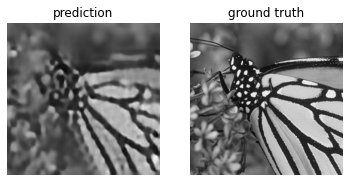

In [7]:
#train model
model = GDCI_8()
#model.compile(optimizer=opt, loss='mse')

model.train(data_train, data_train, epochs=100, batch_size=5)
model.test(data_test, data_test)

In [8]:
def PSNR(y_gt, y_pred):
    mse = np.mean((y_gt - y_pred) ** 2)
    max_pixel = 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr
'''
def regularized_loss(y_true, y_pred):
    return backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))) + 0.01*backend.mean(backend.square(y_pred[:,:,:,2]))
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))))

model = load_model('GADCI_4.h5',custom_objects={"backend": backend,'regularized_loss': regularized_loss,'rmse': rmse})

pred = model.predict_on_batch(data_test)
'''
pred = loadmat("GDCI_8.mat")
pred = pred['GDCI_8']
print(['PSNR: ',str(PSNR(data_test, pred))])

['PSNR: ', '-0.48821745441604325']
